In [93]:
# Import dependencies
from pymongo import MongoClient
import pandas as pd
from pprint import pprint
import datetime

In [54]:
# Create an Instance of MongoClient
mongo = MongoClient(port=27017)

In [55]:
# Confirm new dB was created, list all databases
databases = mongo.list_database_names()
pprint(databases)

['admin', 'config', 'local', 'met', 'sample_mflix', 'uk_food']


In [56]:
# Assign the sample_mflix to a variable name 
db = mongo['sample_mflix']

In [57]:
# Review the collections in our new database 
collections = db.list_collection_names()
pprint(collections)

['users', 'theaters', 'movies', 'sessions', 'comments']


In [89]:
# assign the collections to variables
users = db['users']
theaters = db['theaters']
movies = db['movies']
sessions = db['sessions']
comments = db['comments']

# Simple Query 1
**What are the 10 most recent movie releases in the database? The result should show only the movie title and release date.

In [69]:
# OPTION 1:
# Fetch the 10 most recent movie releases (movie title, release date)
query = {} #select all docs
projection = {'title': 1, 'released': 1, '_id': 0} # Projection: Include title and release date, exclude _id
sort_criteria = [('released', -1)] # Sort by release date in descending order 
limit_value = 10 # limit to 10

# Fetch and format in a concise loop
for movie in movies.find(query, projection).sort(sort_criteria).limit(limit_value):
    formatted_date = movie['released'].strftime('%Y-%m-%d') if 'released' in movie else 'Unknown'
    print(f"title: '{movie['title']}', released date: {formatted_date}")

title: 'The Treasure', released date: 2016-03-23
title: 'Knight of Cups', released date: 2016-03-04
title: 'Sand Castles', released date: 2016-03-01
title: 'Shut In', released date: 2016-02-19
title: 'Dègradè', released date: 2016-02-10
title: 'The Monkey King', released date: 2016-02-08
title: 'Land and Shade', released date: 2016-01-27
title: 'Beauty and the Beast', released date: 2016-01-20
title: 'Remember', released date: 2016-01-15
title: 'Bang Gang (A Modern Love Story)', released date: 2016-01-13


In [95]:
# OPTION 1:
# Ensure only documents with a valid 'released' date are considered
query = {"released": {"$exists": True, "$type": "date"}}
fields = {'title': 1, 'released': 1, '_id': 0} # Include title and release date, exclude _id
sort_criteria = [('released', -1)] # Sort by release date in descending order
limit_value = 10 # Limit to 10

# Fetch and format in a concise loop
for movie in movies.find(query, fields).sort(sort_criteria).limit(limit_value):
    formatted_date = movie['released'].strftime('%Y-%m-%d') if 'released' in movie else 'Unknown'
    print(f"title: '{movie['title']}', released date: {formatted_date}")

title: 'The Treasure', released date: 2016-03-23
title: 'Knight of Cups', released date: 2016-03-04
title: 'Sand Castles', released date: 2016-03-01
title: 'Shut In', released date: 2016-02-19
title: 'Dègradè', released date: 2016-02-10
title: 'The Monkey King', released date: 2016-02-08
title: 'Land and Shade', released date: 2016-01-27
title: 'Beauty and the Beast', released date: 2016-01-20
title: 'Remember', released date: 2016-01-15
title: 'Bang Gang (A Modern Love Story)', released date: 2016-01-13


In [98]:
# OPTION 2:
# Confirming 10 most recently released movies
query =  {"released": {"$exists": True, "$ne": None}}  # Ensure the released field exists and is not null
fields = {"title": 1, "released": 1, "_id": 0}
sort = [("released", -1)]

# Cast the results as a list and save them to a variable
results = list(movies.find(query, fields).sort(sort).limit(10))

for movie in results:
    # Format the 'released' date
    formatted_date = movie['released'].strftime('%Y-%m-%d')
    print(f"Title: '{movie['title']}', Released Date: {formatted_date}")

Title: 'The Treasure', Released Date: 2016-03-23
Title: 'Knight of Cups', Released Date: 2016-03-04
Title: 'Sand Castles', Released Date: 2016-03-01
Title: 'Shut In', Released Date: 2016-02-19
Title: 'Dègradè', Released Date: 2016-02-10
Title: 'The Monkey King', Released Date: 2016-02-08
Title: 'Land and Shade', Released Date: 2016-01-27
Title: 'Beauty and the Beast', Released Date: 2016-01-20
Title: 'Remember', Released Date: 2016-01-15
Title: 'Bang Gang (A Modern Love Story)', Released Date: 2016-01-13


# Simple Query 2:
**How many movies did Harrison Ford appear in in the 1990s?

In [43]:
movies.count_documents({})

23539

In [46]:
# Count of movies w Harrsion Ford during the 1990's
query = {'cast': 'Harrison Ford',
        'year': {'$gte': 1990, '$lte': 1999}}

movies.count_documents(query)

8

# Simple Query 3:
**Which movie involving a horse has the longest runtime?

In [75]:
# Define a query that looks for the mention of "horse" in the plot
query = {
    "$or": [
        {"plot": {"$regex": "horse", "$options": "i"}},
        {"fullplot": {"$regex": "horse", "$options": "i"}}
    ]
}
# Sort by runtime in descending order and limit to 1 to get the longest movie
for movie in movies.find(query).sort("runtime", -1).limit(1):
    print(f"Title: {movie.get('title', 'Unknown')}, Runtime: {movie.get('runtime', 'Unknown')} minutes")

Title: Ryan's Daughter, Runtime: 206 minutes


**This query identified 'horseback' in the Fullplot. If we want to get the word 'horse' or 'horses' then we should alter our code. 

In [76]:
# Create a text index on the 'plot' and 'fullplot' fields
movies.create_index([("plot", "text"), ("fullplot", "text")])

#text search query
query = {"$text": {"$search": "horse horses"}}
for movie in movies.find(query).sort("runtime", -1).limit(1):
    print(f"Title: {movie.get('title', 'Unknown')}, Runtime: {movie.get('runtime', 'Unknown')} minutes")

Title: Giant, Runtime: 201 minutes


# Complex Query 1:
**What is the highest rated (based on IMDB ratings) movie for each year since 1970? HINT: The imdb.rating field does not use a consistent data type; you will need to account for this.

In [71]:
# Define the aggregation pipeline
pipeline = [
    # Ensure we only consider movies with valid numeric IMDb ratings and released from 1970 onwards
    {"$match": {
        "year": {"$gte": 1970},
        "imdb.rating": {"$exists": True, "$type": "number"}
    }},
    # Sort by year and IMDb rating
    {"$sort": {"year": 1, "imdb.rating": -1}},
    # Group by year to get the highest-rated movie for each year
    {"$group": {
        "_id": "$year",
        "highestRating": {"$first": "$imdb.rating"},
        "title": {"$first": "$title"}
    }},
    # Sort the results by year for readability
    {"$sort": {"_id": 1}}
]

df = pd.DataFrame(list(movies.aggregate(pipeline)))

print(df)
        

     _id  highestRating                                              title
0   1970            8.3                                  Michael the Brave
1   1971            8.4                                 A Clockwork Orange
2   1972            9.2                                      The Godfather
3   1973            8.5                             Scenes from a Marriage
4   1974            9.1                             The Godfather: Part II
5   1975            8.7                    One Flew Over the Cuckoo's Nest
6   1976            9.0                                        I, Claudius
7   1977            8.7                                  Jesus of Nazareth
8   1978            8.7                        The Girl with the Red Scarf
9   1979            8.7                          Tinker Tailor Soldier Spy
10  1980            9.3                                             Cosmos
11  1981            8.6                            Raiders of the Lost Ark
12  1982            9.0  

# Complex Query 2:
**Show each of the movie genres in order of average IMDB rating (descending). Include the average rating in the output.

In [78]:
# Define the aggregation pipeline
pipeline = [
    {"$match": {"imdb.rating": {"$type": "number"}}},  # Ensure imdb.rating is a number
    {"$unwind": "$genres"}, #unwind genres to make sub-doc
    {"$group": {
        "_id": "$genres",
        "averageRating": {"$avg": "$imdb.rating"}
    }},
    {"$sort": {"averageRating": -1}}
]

# Execute the aggregation pipeline & print the results
for genre in movies.aggregate(pipeline):
    print(f"Genre: {genre['_id']}, Average IMDB Rating: {genre['averageRating']:.2f}")

Genre: Film-Noir, Average IMDB Rating: 7.50
Genre: Documentary, Average IMDB Rating: 7.37
Genre: Short, Average IMDB Rating: 7.36
Genre: News, Average IMDB Rating: 7.25
Genre: History, Average IMDB Rating: 7.20
Genre: War, Average IMDB Rating: 7.18
Genre: Biography, Average IMDB Rating: 7.10
Genre: Talk-Show, Average IMDB Rating: 7.00
Genre: Music, Average IMDB Rating: 6.92
Genre: Animation, Average IMDB Rating: 6.92
Genre: Western, Average IMDB Rating: 6.88
Genre: Drama, Average IMDB Rating: 6.83
Genre: Sport, Average IMDB Rating: 6.78
Genre: Crime, Average IMDB Rating: 6.73
Genre: Musical, Average IMDB Rating: 6.70
Genre: Romance, Average IMDB Rating: 6.70
Genre: Mystery, Average IMDB Rating: 6.56
Genre: Adventure, Average IMDB Rating: 6.53
Genre: Comedy, Average IMDB Rating: 6.48
Genre: Fantasy, Average IMDB Rating: 6.42
Genre: Action, Average IMDB Rating: 6.38
Genre: Family, Average IMDB Rating: 6.36
Genre: Thriller, Average IMDB Rating: 6.32
Genre: Sci-Fi, Average IMDB Rating: 6.1

# Complex Query 3:
**Analyze commenter trends and present in a manner that would be digestible by C-suite members. This exercise is purposefully open-ended to give you a chance to be creative; however, as an example, imagine a scenario where we are IMDB and movie studios pay us when consumers comment on their movies. What traits (e.g., genre, cast, release date, etc.) do the movies that perform well share? What types of movies should we focus marketing spend on to bring more attention to?

In [100]:
# Define the aggregation pipeline for joining comments counts with movies
pipeline = [
    # Step 1: Group comments by movie_id and count them
    {
        "$group": {
            "_id": "$movie_id",
            "comment_count": {"$sum": 1}
        }
    },
    # Step 2: Perform the lookup (join) with the movies collection
    {
        "$lookup": {
            "from": "movies",  # Specify the collection to join with
            "localField": "_id",  # The field from the comments (this pipeline) for matching
            "foreignField": "_id",  # The matching field from the movies collection
            "as": "movie_details"  # The output array field with joined document
        }
    },
    # Step 3: Unwind movie_details to make sub-document instead of an array
    {
        "$unwind": "$movie_details"
    },
    # Step 4: Project the desired fields
    {
        "$project": {
            "_id": 0,
            "movie_id": "$_id",
            "comment_count": 1,
            "title": "$movie_details.title",
            "genres": "$movie_details.genres",
            "imdb_rating": "$movie_details.imdb.rating"
            # Add any other movie details you want to include
        }
    },
    # Step 5: Sort, limit, or filter the results as needed
    {
        "$sort": {"comment_count": -1}  # Sorting by comment count in descending order
    }
]

# Execute the aggregation pipeline
joined_results = db.comments.aggregate(pipeline)

# You can convert it to a list for easier handling in Python
results_list = list(joined_results)

# Convert the list into a DataFrame
df = pd.DataFrame(results_list)

# Display the DataFrame
print(df.head())  # .head() to display the first few rows


   comment_count                  movie_id                       title  \
0            161  573a13bff29313caabd5e91e  The Taking of Pelham 1 2 3   
1            158  573a13b3f29313caabd3b647        Terminator Salvation   
2            158  573a13a3f29313caabd0d1e3              Ocean's Eleven   
3            158  573a13abf29313caabd25582              50 First Dates   
4            158  573a13a5f29313caabd159a9                 About a Boy   

                      genres imdb_rating  
0  [Action, Crime, Thriller]         6.4  
1           [Action, Sci-Fi]         6.7  
2          [Crime, Thriller]         7.8  
3          [Comedy, Romance]         6.8  
4   [Comedy, Drama, Romance]         7.1  


**Pull back top 10 most commented on movies 

In [102]:
pipeline_top = pipeline + [{"$limit": 10}] 

top_results = list(db.comments.aggregate(pipeline_top))

df_top = pd.DataFrame(top_results)

df_top

,comment_count,movie_id,title,genres,imdb_rating
0,161,573a13bff29313caabd5e91e,The Taking of Pelham 1 2 3,"[Action, Crime, Thriller]",6.4
1,158,573a13a5f29313caabd159a9,About a Boy,"[Comedy, Drama, Romance]",7.1
2,158,573a13b3f29313caabd3b647,Terminator Salvation,"[Action, Sci-Fi]",6.7
3,158,573a13abf29313caabd25582,50 First Dates,"[Comedy, Romance]",6.8
4,158,573a13a3f29313caabd0d1e3,Ocean's Eleven,"[Crime, Thriller]",7.8
5,157,573a13bcf29313caabd57db6,Sherlock Holmes,"[Action, Adventure, Crime]",7.6
6,157,573a139bf29313caabcf3a45,The Mummy,"[Action, Adventure, Fantasy]",7.0
7,155,573a13b0f29313caabd3505e,Hellboy II: The Golden Army,"[Action, Adventure, Fantasy]",7.0
8,154,573a13a0f29313caabd05ae1,The Mummy Returns,"[Action, Adventure, Fantasy]",6.3
9,154,573a13acf29313caabd289b3,Anchorman: The Legend of Ron Burgundy,[Comedy],7.3


Findings:
    Action and Adventure draw engagement
    Well known titles with significant marketing budgets
    Presence of big name stars or titles part of a series

**identify 10 least commented on movies

In [107]:
# Modify the sorting step for least commented movies
pipeline_least = pipeline[:-1] + [{"$sort": {"comment_count": 1}}, {"$limit": 10}]

# Execute the aggregation pipeline for least 10 commented movies
least_results = list(db.comments.aggregate(pipeline_least))

# Convert to DataFrame
df_least = pd.DataFrame(least_results)

df_least

,comment_count,movie_id,title,genres,imdb_rating
0,1,573a13bef29313caabd5cf18,The Karamazov Brothers,[Drama],7.7
1,1,573a13c3f29313caabd6b23d,The Twilight Saga: Breaking Dawn - Part 1,"[Adventure, Drama, Fantasy]",4.9
2,1,573a1399f29313caabcedd12,Lush Life,[Drama],6.7
3,1,573a13a7f29313caabd1a90b,Drive,[Crime],7.2
4,1,573a13bef29313caabd5d304,The Wackness,"[Comedy, Drama, Romance]",7.0
5,1,573a13aef29313caabd2e720,Rosario Tijeras,"[Crime, Drama, Romance]",6.4
6,1,573a139af29313caabcf0375,Viva Erotica,"[Comedy, Drama]",6.7
7,1,573a13bcf29313caabd5784f,The Chronicles of Narnia: The Voyage of the Da...,"[Adventure, Family, Fantasy]",6.3
8,1,573a13b5f29313caabd41f54,Khosla's Nest,"[Comedy, Crime, Drama]",8.4
9,1,573a1399f29313caabcec434,Wild at Heart,"[Comedy, Crime, Thriller]",7.3


Findings:
    Diverse Genres but lower engagement
    IMDb ratings not always correlated with engagement
    possible lack of promotional activity

**Identify which Genre is most commented on

In [118]:
#Join Comments and movies
lookup_movies = {
    "$lookup": {
        "from": "movies",  # the collection to join
        "localField": "movie_id",  # the field from the comments collection
        "foreignField": "_id",  # the matching field from the movies collection
        "as": "movie"  # the output array field
    }}

# Step 2: Unwind the result of the join to treat each matched movie as a separate document
unwind_movie = {
    "$unwind": "$movie"
}

# Now include the previously defined operations
unwind_genres = {
    "$unwind": "$movie.genres"  # Adjusted to unwind genres from the movie document
}

group_by_genre = {
    "$group": {
        "_id": "$movie.genres",
        "comment_count": {"$sum": 1},  # Count comments for each genre
        "average_imdb_rating": {"$avg": "$movie.imdb.rating"}  # Calculate average IMDb rating
    }}

sort_by_comment_count = {
    "$sort": {"comment_count": -1}  # Sort by average comments in descending order
}

# Assemble the updated pipeline
genre_analysis_pipeline = [
    lookup_movies,
    unwind_movie,
    unwind_genres,
    group_by_genre,
    sort_by_comment_count
]

In [119]:
# Execute the pipeline
genre_analysis_results = list(db.comments.aggregate(genre_analysis_pipeline))


In [121]:
# Convert to DataFrame
df_genre_analysis = pd.DataFrame(genre_analysis_results)

df_genre_analysis

,_id,comment_count,average_imdb_rating
0,Comedy,15607,6.655688
1,Drama,12988,7.239292
2,Adventure,12423,7.193464
3,Action,11481,7.039930
4,Fantasy,6988,7.200630
5,Romance,5750,6.820351
6,Thriller,5691,7.048567
7,Crime,5025,7.272677
8,Family,4748,6.854666
9,Sci-Fi,4544,7.052884


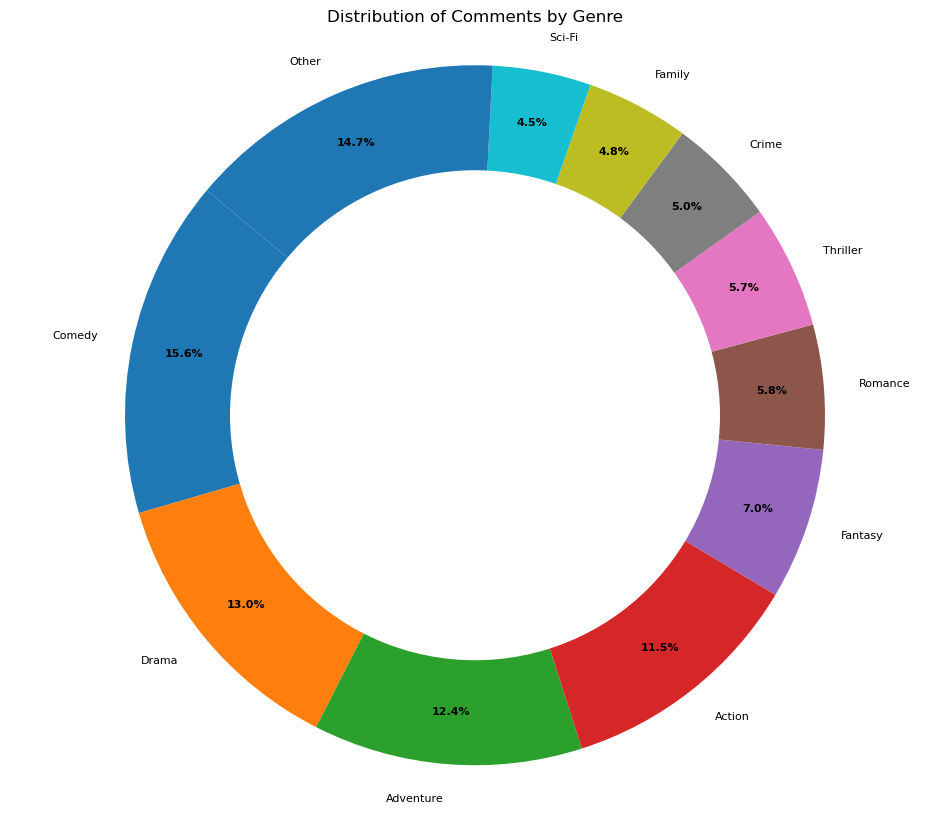

In [123]:
# Plot Distribution of comments by Genre in Donut Chart

import matplotlib.pyplot as plt

genres = df_genre_analysis['_id'].tolist()
comment_counts = df_genre_analysis['comment_count'].tolist()

# Create a new list for adjusted genre labels and comment counts
adjusted_genres = []
adjusted_counts = []
other_count = 0
threshold = 0.04  # Set a threshold for the smallest percentage to display

# Sum up small slices into "Other" category
for genre, count in zip(genres, comment_counts):
    if count / sum(comment_counts) < threshold:
        other_count += count
    else:
        adjusted_genres.append(genre)
        adjusted_counts.append(count)

# If there's an "Other" category, add it to the lists
if other_count > 0:
    adjusted_genres.append('Other')
    adjusted_counts.append(other_count)

plt.figure(figsize=(12, 10))  # Increase the figure size if needed
wedges, texts, autotexts = plt.pie(adjusted_counts, labels=adjusted_genres, autopct=lambda pct: "{:.1f}%".format(pct) if pct >= threshold else '',
                                   startangle=140, pctdistance=0.85)

# Increase the text size
plt.setp(texts, size=8)
plt.setp(autotexts, size=8, weight="bold")

# Draw a circle at the center to make it a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Distribution of Comments by Genre')
plt.axis('equal')  # Ensures that pie is drawn as a circle.
plt.show()


# Findings:
1. Comedy, Drama, and Adventure are the top three most commented genres. This indicates a high audience engagement. This genre could represent the most popular or polarizing movies, prompting viewers to share their opinons. 
2. While Comedy has the highest number of comments, its average IMDb rating is relatively lower than genres like Drama and Adventure.
3. Genres like War, Documentary, and History have lower comment counts but higher IMDb ratings. This could imply that the genres are more niche and have a dedicated audience.

# Recommendations
1. For Marketing focus, invest more in marketing movies within Comedy, Drama, and Adventure.
2. From a Content Strategy perspective, consider acquiring more titles in the War, Documentary, and History genres.This could attract a dedicated audience potentially increasing subscriber retention.
3. As a community building recommendation, encourage community discussions around movies with high comment counts to enhance user engagement. i.e. Q&A sessions with directors or actors of a particular movie